# Automatizace ve fyzice: OpenCV podruhé

Petr Čermák  
2024-11-07

## Připojte se

[cermak.science/teaching/automation/lectures/06-opencv-2/](https://cermak.science/teaching/automation/lectures/06-opencv-2/presentation.html)

## Domácí úkol č. 1

Discord –\> @nfpl242_automatizace –\> pište DM

`$vsm_measure PROJECT TOKEN [branch]`

default branch je `master`, PROJECT je číslo projektu

-   robot provede měření,
-   uloží data na server
-   vytriggeruje vaší pipeline
-   dá mi vědět, že jste úkol odevzdali

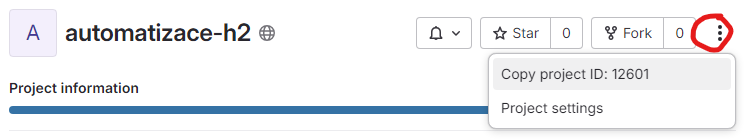 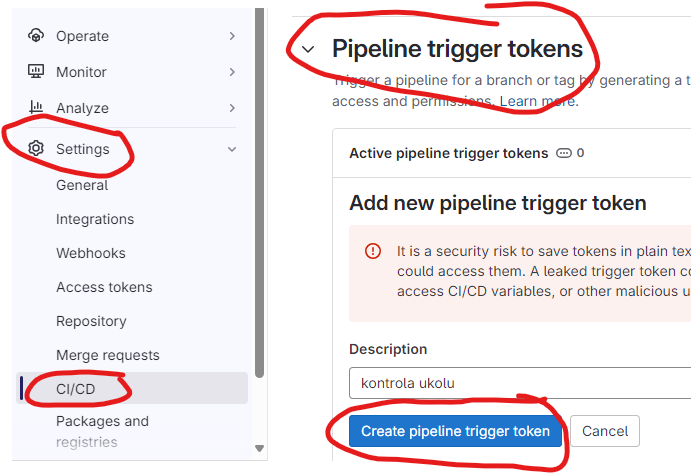

# Detekce objektů

## Opakování

1.  Načíst soubor

. . .

In [1]:
import cv2 as cv
img = cv.imread("thea.jpg")

. . .

1.  Převést do šedé

. . .

In [2]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

. . .

1.  Rozostřit

. . .

In [3]:
blur = cv.medianBlur(gray, 7)

. . .

1.  Práh nebo Hrany

. . .

In [4]:
binary = cv.adaptiveThreshold(blur,255,\
  cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
  cv.THRESH_BINARY,11,2)

. . .

1.  Obrysy

. . .

In [5]:
c, _ = cv.findContours(binary, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
print(f'{len(c)} contour(s) found!')

86928 contour(s) found!

## Barevné prostory

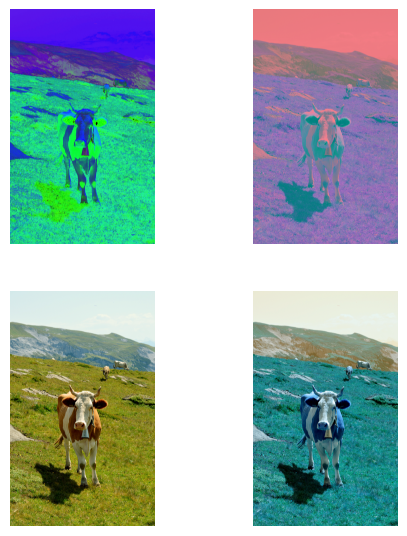

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,7)); 

# BGR to HSV
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
plt.subplot(2,2,1); plt.imshow(hsv)
plt.axis('off')

# BGR to L*a*b
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
plt.subplot(2,2,2); plt.imshow(lab)
plt.axis('off')

# BGR to RGB
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.subplot(2,2,3); plt.imshow(rgb)
plt.axis('off')

# BGR
plt.subplot(2,2,4); plt.imshow(img)
plt.axis('off')

plt.show()

## Jednotlivé složky RGB

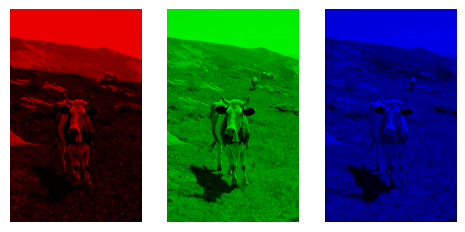

In [7]:
blank = np.zeros(img.shape[:2], dtype='uint8')

b,g,r = cv.split(img)

plt.figure(figsize=(6,7)); 

blue = cv.merge([b,blank,blank])
green = cv.merge([blank,g,blank])
red = cv.merge([blank,blank,r])

plt.subplot(1,3,1);plt.imshow(blue);plt.axis('off')
plt.subplot(1,3,2);plt.imshow(green);plt.axis('off')
plt.subplot(1,3,3);plt.imshow(red);plt.axis('off')

plt.show()

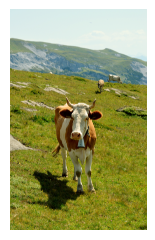

In [8]:
plt.figure(figsize=(4,3)); 
plt.imshow(rgb)
plt.axis('off')
plt.show()

## Jednotlivé složky HSV

-   odstín, hue (0 a 360 = červená, 120 = zelená, 240 = modrá).
-   sytost (0 - 100)
-   jas (0 - 100)
-   podobné HSL, což je více pro design

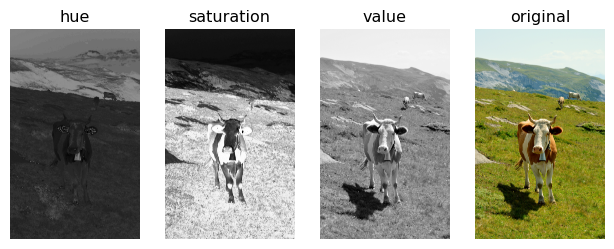

In [9]:
h,s,v = cv.split(hsv)

plt.figure(figsize=(8,7)); 

plt.subplot(1,4,1); plt.imshow(h, cmap='gray')
plt.title('hue')
plt.axis('off')

plt.subplot(1,4,2); plt.imshow(s, cmap='gray')
plt.title('saturation')
plt.axis('off')

plt.subplot(1,4,3); plt.imshow(v, cmap='gray')
plt.title('value')
plt.axis('off')

plt.subplot(1,4,4); plt.imshow(rgb)
plt.title('original')
plt.axis('off')

plt.show()

## Jednotlivé složky Lab

-   světelnost (0-100)
-   zelená \<-\> červená (-128 - 127)
-   modrá \<-\> žlutá (-128 - 127)

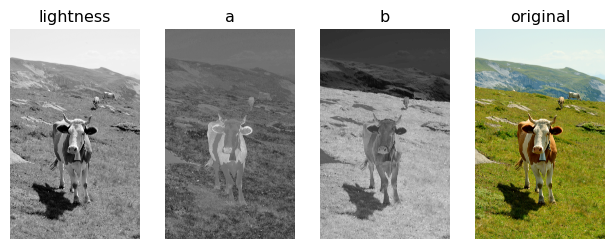

In [10]:
h,s,v = cv.split(lab)

plt.figure(figsize=(8,7)); 

plt.subplot(1,4,1); plt.imshow(h, cmap='gray')
plt.title('lightness')
plt.axis('off')

plt.subplot(1,4,2); plt.imshow(s, cmap='gray')
plt.title('a')
plt.axis('off')

plt.subplot(1,4,3); plt.imshow(v, cmap='gray')
plt.title('b')
plt.axis('off')

plt.subplot(1,4,4); plt.imshow(rgb)
plt.title('original')
plt.axis('off')

plt.show()

## Histogramy

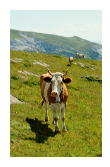

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(4,2)); 
plt.imshow(rgb);plt.axis('off')
plt.show()

. . .

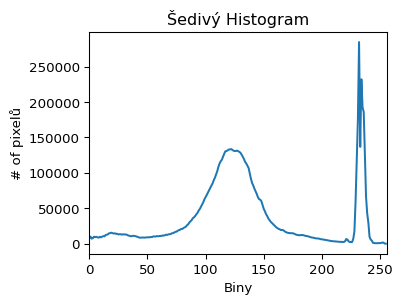

In [12]:
gray_hist = cv.calcHist(
  [gray], # zdroj
  [0],    # kanál
  None,   # maska
  [256],  # počet binů
  [0,256] # rozsah
)

plt.figure(figsize=(4,3))
plt.title('Šedivý Histogram')
plt.xlabel('Biny')
plt.ylabel('# of pixelů')
plt.plot(gray_hist)
plt.xlim([0,256])
plt.show()

## Histogramy

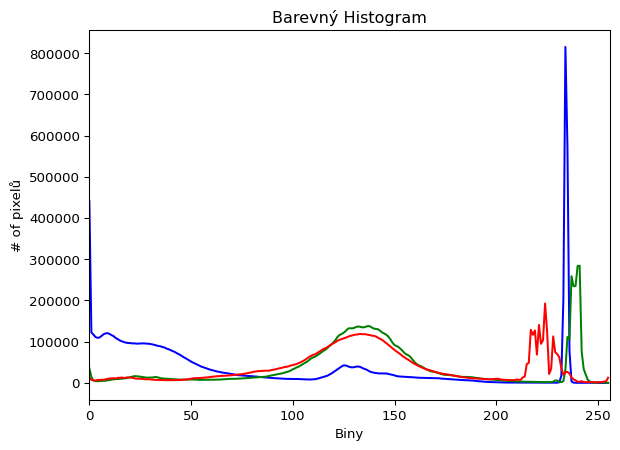

In [13]:
plt.figure()
plt.title('Barevný Histogram')
plt.xlabel('Biny')
plt.ylabel('# of pixelů')
colors = ('b', 'g', 'r')
for i,col in enumerate(colors):
    hist = cv.calcHist([img], [i],
       None, [256], [0,256])
    plt.plot(hist, color=col)
    plt.xlim([0,256])

# Detekce a kategorizace

## Haar cascade

> Viola, P. and Jones, M. Rapid object detection using a boosted cascade
> of simple features. Proceedings of CVPR 2001 (Vol. 1, 2001)
> [doi:10.1109/CVPR.2001.990517](https://ieeexplore.ieee.org/document/990517)

-   data se natrénují na setu obrázků s objektem a bez objektu
-   obrázek procházen jádrem s nějakým Haarovým rysem
    -   odečítá se intenzita pod černým - bílým polem
    -   různé velikosti jader - mnoho rysů obrázku
-   rysy promazány a protříděny do etap
-   kaskádové - kde nic není, vyhodnotí se to rychle jako prázdno

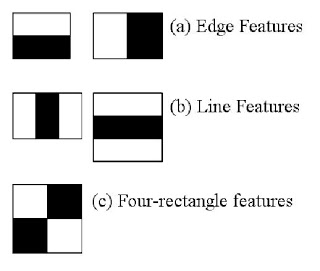

## Detekce obličejů

OpenCV obsahuje [předučená
data](https://github.com/opencv/opencv/tree/master/data/haarcascades).

Nalezeno 29 obličejů.

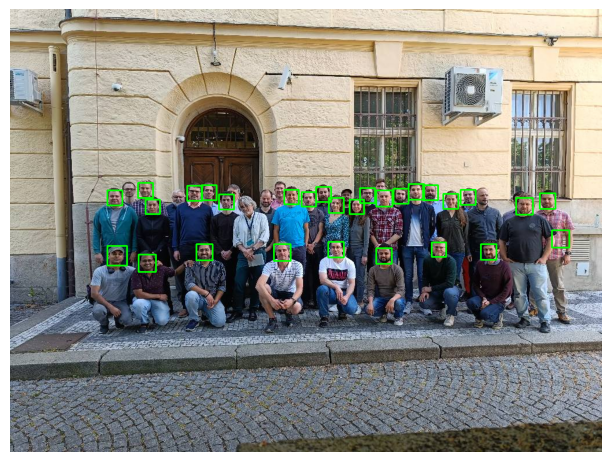

In [14]:
people = cv.imread('people.jpg')
people = cv.cvtColor(people, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(people, cv.COLOR_BGR2GRAY)
#gray = cv.equalizeHist(gray)
haar_cascade = cv.CascadeClassifier('haar_face.xml')
faces_rect = haar_cascade.detectMultiScale(
  gray, scaleFactor=1.06, minNeighbors=4)
for (x,y,w,h) in faces_rect:
    cv.rectangle(people, (x,y), (x+w,y+h), 
                 (0,255,0), thickness=2)

print(f'Nalezeno {len(faces_rect)} obličejů.')
plt.figure(figsize=(8,6)); 
plt.imshow(people)
plt.axis('off')
plt.show()

## Vlastní data

-   Potřebujeme:
    -   pozitivních data (kde jsou objekty)
    -   negativní data (kde nic není)
-   Pozitivní lze vygenerovat (např. pro logo, hrot)
    -   `opencv_createsamples`
    -   alternativně je sw jen upraví
    -   `opencv_annotation` - naklikáte objekty z obrázku
-   `opencv_traincascade`
    -   hlavní nástroj, mnoho parametrů
-   `opencv_visualisation`
    -   zobrazí, jaké rysy sleduje a v jakých etapách

**Pozor:** Tyto nástroje nejsou součástí OpenCV 4, nutno stáhnout starou
verzi.

# Příští hodina 14.11. odpadá

# Cvičení

## Detekce obličejů

Úkol - kolik lidí je v KFKL na oddělení?

1.  Stáhnout
    [cermak.science/teaching/automation/lectures/06-opencv-2/people.jpg](https://cermak.science/teaching/automation/lectures/06-opencv-2/people.jpg)
2.  Pohrát si s barevnými prostory, vyvážení barev
3.  Použít `haar_cascade.detectMultiScale`
4.  Vytvořit docker CI pomocí image
    `hdgigante/python-opencv:4.10.0-alpine`

# Příští hodina 14.11. odpadá